# Qualitative checks
Natalia Vélez, July 2022

Check qualitative predictions of the model against human behavior. This notebook was used to generate a lot of the supporting figures that you see in the manuscript!

In [1]:
%matplotlib inline

# general
import sys, pprint
from os.path import join as opj
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from scipy import stats
import scipy.ndimage as ndimage
from scipy.spatial import distance

# project-specific
import teaching_models as teach
sys.path.append('..')
import utils

# plotting settings
sns.set_style('white')
sns.set_context('talk')

Loading teaching problems
{'A': [[0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 0]],
 'B': [[1, 1, 1, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'C': [[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]],
 'D': [[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]]}
Participants excluded from analysis:
[3, 17]
Cleaning up human behavioral data
    subject  run  block_idx  ex_idx first_movement   start  problem  \
0         1    1          0       0         [0, 1]  [0, 0]       22   
1         1    1          0       1         [0, 1]  [0, 0]       22   
3         1    1          1   

## Fig S2: Setting recursive depth

Load behavioral data:

In [2]:
teacher_df = teach.human_df.copy()
teacher_df['teacher'] = [f'sub-{s:02}' for s in teacher_df.subject]
teacher_df.head()

,subject,run,block_idx,ex_idx,first_movement,start,problem,order,example,cursor_coords,example_coords,cursor,teacher
0,1,1,0,0,"[0, 1]","[0, 0]",22,"['C', 'B', 'D', 'A']",8,"[0, 0]","[1, 2]",0,sub-01
1,1,1,0,1,"[0, 1]","[0, 0]",22,"['C', 'B', 'D', 'A']",27,"[1, 2]","[4, 3]",8,sub-01
3,1,1,1,0,"[0, 4]","[0, 5]",18,"['D', 'B', 'C', 'A']",3,"[0, 5]","[0, 3]",5,sub-01
4,1,1,1,1,"[0, 4]","[0, 5]",18,"['D', 'B', 'C', 'A']",32,"[0, 3]","[5, 2]",3,sub-01
5,1,1,1,2,"[0, 4]","[0, 5]",18,"['D', 'B', 'C', 'A']",7,"[5, 2]","[1, 1]",32,sub-01


Select participant for demo:

In [3]:
sub = 'sub-30'
sub_data = teacher_df[teacher_df.teacher == sub].copy()
sub_data.head()

,subject,run,block_idx,ex_idx,first_movement,start,problem,order,example,cursor_coords,example_coords,cursor,teacher
3468,30,1,0,0,"[5, 1]","[5, 0]",31,"['B', 'C', 'D', 'A']",31,"[5, 0]","[5, 1]",30,sub-30
3469,30,1,0,1,"[5, 1]","[5, 0]",31,"['B', 'C', 'D', 'A']",26,"[5, 1]","[4, 2]",31,sub-30
3470,30,1,0,2,"[5, 1]","[5, 0]",31,"['B', 'C', 'D', 'A']",8,"[4, 2]","[1, 2]",26,sub-30
3471,30,1,1,0,"[1, 5]","[0, 5]",37,"['A', 'D', 'C', 'B']",17,"[0, 5]","[2, 5]",5,sub-30
3472,30,1,1,1,"[1, 5]","[0, 5]",37,"['A', 'D', 'C', 'B']",22,"[2, 5]","[3, 4]",17,sub-30


Plot belief distributions for a particular problem:

In [4]:
prob_idx = 3
prob_data = sub_data[sub_data.problem == prob_idx].copy().reset_index(drop=True)

past_examples = []
prag_list = []
lit_list = []
lit_pH = None
prag_pH = None

for t, row in prob_data.iterrows():
    _, prag_pH = teach.pedagogical_sampling(prob_idx, past_examples=past_examples, last_pH=prag_pH, nIter=10)
    prag_pHD = prag_pH.loc[row.example]
    prag_list.append(prag_pHD.copy())
    
    _, lit_pH = teach.strong_sampling(prob_idx, past_examples=past_examples, last_pH=lit_pH, nIter=10)
    lit_pHD = lit_pH.loc[row.example]
    lit_list.append(lit_pHD.copy())

    past_examples.append(row.example)

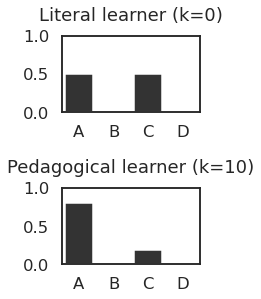

In [5]:
fig, axes = plt.subplots(2,1, figsize=(3,3*1.5))
sns.barplot(x=lit_list[0].index.values, y=lit_list[0].values, ax=axes[0], fc='#333')
axes[0].set_title('Literal learner (k=0)', pad=15)
# axes[0].set_xticks(['A', 'B', 'C', 'D'])
axes[0].set_ylim((0,1))

sns.barplot(x=prag_list[0].index.values, y=prag_list[0].values, ax=axes[1], fc='#333')
axes[1].set_title('Pedagogical learner (k=10)', pad=15)
# axes[0].set_xticks(['A', 'B', 'C', 'D'])

axes[1].set_ylim((0,1))

fig.tight_layout()
plt.savefig('plots/recursive_depth_demo.png', bbox_inches='tight')

Helper function: KL divergence

In [6]:
def bump_dist(d):
    d_adjusted = d+0.0001
    d_adjusted = d_adjusted/np.sum(d_adjusted)
    
    return d_adjusted

def kl_divergence(dist1, dist2):
    d1_adj = bump_dist(dist1)
    d2_adj = bump_dist(dist2)
    
    kl = stats.entropy(d1_adj, d2_adj)
    return kl

Get belief distribution as a function of # of iterations:

In [7]:
prag_pH = None
depth_list = []
last_pH = lit_list[0]

row = prob_data.iloc[0]
for k in range(1,30):
    _, prag_pH = teach.pedagogical_sampling(prob_idx, nIter=k)
    prag_pHD = prag_pH.loc[row.example]
    depth_list.append((k, kl_divergence(last_pH, prag_pHD)))
    
    last_pH = prag_pHD
    
depth_df = pd.DataFrame(depth_list, columns=['depth', 'kl'])
depth_df.head()

,depth,kl
0,1,0.036300
1,2,0.008769
2,3,0.003221
3,4,0.001456
4,5,0.000746


Plot KL divergences:

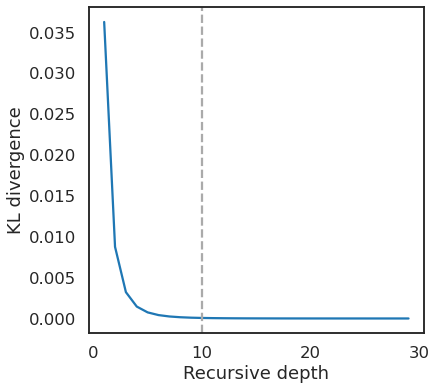

In [8]:
fig,ax=plt.subplots(figsize=(6,6))
sns.lineplot(data=depth_df, x='depth', y='kl',ax=ax)
ax.axvline(10, linestyle='--', color='#aaa')
ax.set(xlabel='Recursive depth', ylabel='KL divergence')
plt.savefig('plots/recursive_demo.png', bbox_inches='tight')

## Fig 3c-g: Predictive checks for a single participant

Load model evidences:

In [9]:
evidence_df = pd.read_csv('outputs/human_model_comparison/human_model_evidence_summary.csv', index_col=0)
evidence_df.head()

,sub,model,loglik,example,n_param,BIC,model_evidence
0,sub-01,cost,-248.913569,108,1,502.509269,-251.254634
1,sub-01,literal_cost,-241.494859,108,2,492.353980,-246.176990
2,sub-01,literal,-252.244198,108,1,509.170526,-254.585263
3,sub-01,literal_pref_cost,-213.466264,108,3,440.978922,-220.489461
4,sub-01,literal_pref,-227.600676,108,2,464.565614,-232.282807


Choose participant for demo:

In [10]:
sub = 'sub-20'

Find model parameters:

In [11]:
param_files = utils.gsearch('outputs', 'fit_model-*_method-optimize', f'{sub}*.json')
utils.print_list(param_files)

Found 11 items
outputs/fit_model-pragmatic_pref_cost_method-optimize/sub-20_model-pragmatic_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_cost_method-optimize/sub-20_model-literal_pref_cost_method-optimize_result.json
outputs/fit_model-literal_pref_method-optimize/sub-20_model-literal_pref_method-optimize_result.json
outputs/fit_model-literal_cost_method-optimize/sub-20_model-literal_cost_method-optimize_result.json
outputs/fit_model-pref_cost_method-optimize/sub-20_model-pref_cost_method-optimize_result.json
outputs/fit_model-literal_method-optimize/sub-20_model-literal_method-optimize_result.json
outputs/fit_model-pref_method-optimize/sub-20_model-pref_method-optimize_result.json
outputs/fit_model-cost_method-optimize/sub-20_model-cost_method-optimize_result.json
outputs/fit_model-pragmatic_method-optimize/sub-20_model-pragmatic_method-optimize_result.json
outputs/fit_model-pragmatic_cost_method-optimize/sub-20_model-pragmatic_cost_method-optimize_result.json
.

Load parameters:

In [12]:
param_dict = {}

for f in param_files:
    # load weights
    res = utils.read_json(f)
    fixed_weights = np.array(res['weights'])
    fit_weights = np.array(res['x'])

    # stitch them together
    full_weights = fixed_weights.copy()
    full_weights[fixed_weights == None] = fit_weights

    param_dict[res['label']] = full_weights
    
pprint.pprint(param_dict)

{'cost': array([0, 0, 4.394292477289438], dtype=object),
 'literal': array([3.2954503206825017, 0, 0], dtype=object),
 'literal_cost': array([3.7183721352760886, 0, 4.957961526696202], dtype=object),
 'literal_pref': array([3.440085187942758, 32.41582128503878, 0], dtype=object),
 'literal_pref_cost': array([3.9380250358474216, 38.99434197065694, 5.234146287856395],
      dtype=object),
 'pragmatic': array([1.416542399822127, 0, 0], dtype=object),
 'pragmatic_cost': array([1.6518078190526955, 0, 4.87513731100828], dtype=object),
 'pragmatic_pref': array([1.2499639898665962, 29.655706184161993, 0], dtype=object),
 'pragmatic_pref_cost': array([1.5287830441113308, 35.405281977883966, 5.087727754061743],
      dtype=object),
 'pref': array([0, 31.142392903413263, 0], dtype=object),
 'pref_cost': array([0, 36.11688326511599, 4.560678791732778], dtype=object)}


Load problem data:

In [13]:
prob_idx = 23

prob = teach.problems[prob_idx]
true_h = np.array(prob['A'])

prob_data = (
    teacher_df
    [(teacher_df.teacher == sub) & (teacher_df.problem == prob_idx)]
    .copy()
    .reset_index(drop=True)
    .rename(columns={'ex_idx': 't'})
)

prob_data

,subject,run,block_idx,t,first_movement,start,problem,order,example,cursor_coords,example_coords,cursor,teacher
0,20,8,3,0,"[5, 0]","[5, 0]",23,"['B', 'C', 'D', 'A']",2,"[5, 0]","[0, 2]",30,sub-20
1,20,8,3,1,"[5, 0]","[5, 0]",23,"['B', 'C', 'D', 'A']",8,"[0, 2]","[1, 2]",2,sub-20
2,20,8,3,2,"[5, 0]","[5, 0]",23,"['B', 'C', 'D', 'A']",9,"[1, 2]","[1, 3]",8,sub-20


Generate trial-by-trial model predictions:

In [14]:
models_to_compare = ['literal_pref_cost', 'literal', 'pref', 'cost']

def plot_model(m, base_size=3, accent_col='white'):    
    weights = param_dict[m]

    pred = teach.utility_model_predictions(data=prob_data, sampling_fun=teach.strong_sampling, 
                                           pref_fun=teach.edge_pref, weights=weights, nIter=1)

    fig,axes=plt.subplots(1,len(pred), figsize=(base_size*len(pred), base_size))
    past_examples = []
    labels_mtx = np.empty((6,6), dtype=str)

    for t,pred_t in enumerate(pred):
        pD_tuples = pred_t['pD']
        pD = pd.DataFrame(pD_tuples, columns=['idx', 'A']).set_index('idx')
        pD_mtx = teach.sampling_matrix(pD)
        sns.heatmap(pD_mtx, cmap='viridis', square=True, cbar=False, ax=axes[t])
        axes[t].set(xticks=[], yticks=[], title=f't = {t}')

        curr_ex = np.unravel_index(pred_t['example'], (6,6))
        curr_ex = curr_ex[::-1]

        axes[t].add_patch(
            patches.Rectangle(curr_ex, 1.0, 1.0, fill=None, edgecolor='white', lw=4)
        )

        for idx,ex in enumerate(past_examples):        
            axes[t].add_patch(
                patches.Rectangle(ex, 1.0, 1.0, fc='white', edgecolor='white', lw=2)
            )

            axes[t].text(ex[0]+.25, ex[1]+.75, idx+1, fontsize=base_size/1.5*10)

        past_examples.append(curr_ex)

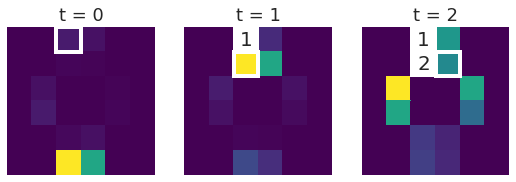

In [15]:
plot_model(models_to_compare[0])
plt.savefig('plots/predictive_full.png')

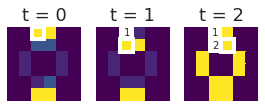

In [16]:
plot_model(models_to_compare[1], 1.5)
plt.savefig('plots/predictive_belief.png')

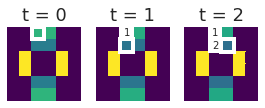

In [17]:
plot_model(models_to_compare[2], 1.5)
plt.savefig('plots/predictive_edge.png')

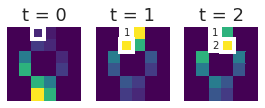

In [18]:
plot_model(models_to_compare[3], 1.5)
plt.savefig('plots/predictive_cost.png')

## Fig S3: Comparing teachers' preferences against simulated data

Load simulated datasets:

In [19]:
sim_dir = opj('outputs', 'simulated_from_human')
sim_files = [opj(sim_dir, f'simulated_data_model-{m}.csv') for m in ['literal', 'pragmatic']]

sim_df = pd.concat([pd.read_csv(f) for f in sim_files])
sim_df['Source'] = sim_df.model.str.extract('(literal|pragmatic)')
sim_df['Source'] = sim_df.model.str.replace('pragmatic', 'pedagogical')
sim_df['Source'] = sim_df.Source.str.title()
sim_df['ex_idx'] = sim_df.groupby(['subject', 'problem', 'Source']).cumcount()
sim_df = sim_df[['subject', 'Source', 'problem', 'ex_idx', 'cursor', 'example']].copy()

print(sim_df.shape)
sim_df.head()

(6720, 6)


,subject,Source,problem,ex_idx,cursor,example
0,sub-01,Literal,0,0,30,14
1,sub-01,Literal,0,1,14,9
2,sub-01,Literal,0,2,9,22
3,sub-01,Literal,1,0,35,8
4,sub-01,Literal,1,1,8,32


Clean up human data:

In [20]:
human_df = teacher_df.copy()
human_df['subject'] = [f'sub-{s:02}' for s in teacher_df.subject]
human_df['Source'] = 'Human'
human_df = human_df[['subject', 'Source', 'problem', 'ex_idx', 'cursor', 'example']].copy()

print(human_df.shape)
human_df.head()

(3213, 6)


,subject,Source,problem,ex_idx,cursor,example
0,sub-01,Human,22,0,0,8
1,sub-01,Human,22,1,8,27
3,sub-01,Human,18,0,5,3
4,sub-01,Human,18,1,3,32
5,sub-01,Human,18,2,32,7


Merge data:

In [21]:
sim_vs_human = pd.concat([sim_df, human_df])
sim_vs_human.groupby('Source').agg({'example': 'count'})

,example
Source,
Human,3213
Literal,3360
Pedagogical,3360


Helper function: Count # of neighbors:

In [22]:
def count_neighbors(prob_idx):
    prob = teach.problems[prob_idx]
    true_h = np.array(prob['A'])

    # kernel used to count neighbors
    footprint = np.array([[1,1,1],
                          [1,0,1],
                          [1,1,1]])

    # expand array
    h_expanded = np.zeros((8,8), dtype=int)
    h_expanded[1:7,1:7] = true_h

    # count # neighbors
    prob_arr = np.array(list(prob.values()))
    expanded_neighbors = ndimage.generic_filter(h_expanded, teach.filter_func, footprint=footprint)

    #clean up output
    n_neighbors = expanded_neighbors[1:7, 1:7]
    n_neighbors = np.multiply(true_h, n_neighbors)

    return n_neighbors

Plot number of neighbors for a representative problem:

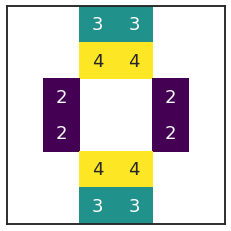

In [23]:
neighbors = count_neighbors(prob_idx)
true_h = np.array(teach.problems[prob_idx]['A'])
ax = sns.heatmap(neighbors, square=True, cmap='viridis', cbar=False, annot=True, mask=1-true_h)
ax.set(xticks=[], yticks=[])
for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.savefig('plots/neighbors_demo.png')

Precompute # of neighbors for all problems:

In [24]:
all_neighbors = np.zeros((40,36), dtype=int)

for i,_ in enumerate(teach.problems):
    neighbors_i = count_neighbors(i)
    neighbors_i_flat = neighbors_i.reshape(36,)
    all_neighbors[i,:] = neighbors_i_flat
    
print(all_neighbors[prob_idx,:])

[0 0 3 3 0 0 0 0 4 4 0 0 0 2 0 0 2 0 0 2 0 0 2 0 0 0 4 4 0 0 0 0 3 3 0 0]


Helper function: Compute movement distance

In [25]:
def movement_distance(cursor, example):
    cursor_2d = np.unravel_index(cursor, (6,6))
    example_2d = np.unravel_index(example, (6,6))
    dist = distance.cityblock(cursor_2d, example_2d)
    return dist

Plot movement distances for a representative problem:

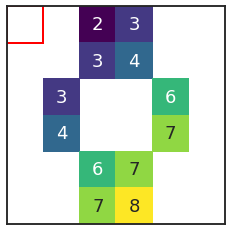

In [26]:
dist_mtx = np.array([movement_distance(0,i) for i in range(36)])
dist_mtx = dist_mtx.reshape((6,6))
dist_mtx = np.multiply(true_h, dist_mtx)

ax = sns.heatmap(dist_mtx, square=True, cmap='viridis', cbar=False, annot=True, mask=1-true_h)
ax.set(xticks=[], yticks=[])
ax.add_patch(patches.Rectangle((0,0), 1.0, 1.0, fill=None, edgecolor='red', lw=2))
for _, spine in ax.spines.items():
    spine.set_visible(True)

plt.savefig('plots/distance_demo.png')

Add # of neighbors, distance to dataframe:

In [27]:
sim_vs_human['distance'] = sim_vs_human.apply(lambda row: movement_distance(row.cursor, row.example), axis=1)
sim_vs_human['neighbors'] = sim_vs_human.apply(lambda row: all_neighbors[row.problem, row.example], axis=1)

sim_vs_human.head()

,subject,Source,problem,ex_idx,cursor,example,distance,neighbors
0,sub-01,Literal,0,0,30,14,5,8
1,sub-01,Literal,0,1,14,9,2,7
2,sub-01,Literal,0,2,9,22,3,7
3,sub-01,Literal,1,0,35,8,7,8
4,sub-01,Literal,1,1,8,32,4,5


Plot distribution of movement distances:

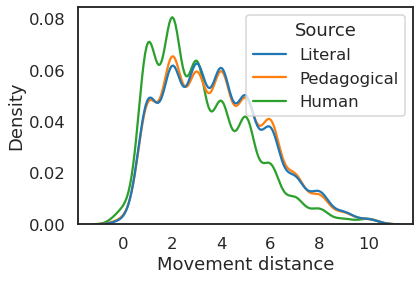

In [28]:
ax = sns.kdeplot(data=sim_vs_human, x='distance', hue='Source')
ax.set(xlabel='Movement distance', xticks=np.linspace(0,int(max(sim_vs_human.distance)), 6))
plt.savefig('plots/distance_sim_vs_human.png', bbox_inches='tight')

Compare distances traveled by humans vs. models:

In [29]:
def welch_dof(x_orig,y_orig):
    '''
    Helper function: Tally degrees of freedom
    Source: https://pythonfordatascienceorg.wordpress.com/welch-t-test-python-pandas/
    '''
    x = x_orig[~np.isnan(x_orig)]
    y = y_orig[~np.isnan(y_orig)]
    
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    print(f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

distance_df = sim_vs_human.pivot(index=['subject', 'problem', 'ex_idx'],columns=['Source'], values=['distance'])

print('vs. Literal:')
lit_dist = stats.ttest_ind(distance_df[('distance', 'Human')].values,
                           distance_df[('distance', 'Literal')].values,
                           equal_var=False, nan_policy='omit')
lit_dist_dof = welch_dof(distance_df[('distance', 'Human')].values,
                         distance_df[('distance', 'Literal')].values)
print(lit_dist)
print(lit_dist_dof)

print('\nvs. Pragmatic:')
prag_dist = stats.ttest_ind(distance_df[('distance', 'Human')].values,
                            distance_df[('distance', 'Pedagogical')].values,
                            equal_var=False, nan_policy='omit')
prag_dist_dof = welch_dof(distance_df[('distance', 'Human')].values,
                          distance_df[('distance', 'Pedagogical')].values)

print(prag_dist)
print(prag_dist_dof)

vs. Literal:
Welch-Satterthwaite Degrees of Freedom= 6569.7865
Ttest_indResult(statistic=-12.769921196171858, pvalue=6.612573955020661e-37)
None

vs. Pragmatic:
Welch-Satterthwaite Degrees of Freedom= 6569.7856
Ttest_indResult(statistic=-12.727625393163681, pvalue=1.1227575223767806e-36)
None


Compare neighbors surrounding examples chosen by humans vs. models:

In [30]:
neighbor_df = sim_vs_human.pivot(index=['subject', 'problem', 'ex_idx'],columns=['Source'], values=['neighbors'])

print('vs. Literal:')
lit_neighbors = stats.ttest_ind(neighbor_df[('neighbors', 'Human')].values,
                                neighbor_df[('neighbors', 'Literal')].values,
                                equal_var=False, nan_policy='omit')
lit_neighbors_dof = welch_dof(neighbor_df[('neighbors', 'Human')].values,
                              neighbor_df[('neighbors', 'Literal')].values)
print(lit_neighbors)
print(lit_neighbors_dof)


print('\nvs. Pragmatic:')
prag_neighbors = stats.ttest_ind(neighbor_df[('neighbors', 'Human')].values,
                                 neighbor_df[('neighbors', 'Pedagogical')].values,
                                 equal_var=False, nan_policy='omit')
prag_neighbors_dof = welch_dof(neighbor_df[('neighbors', 'Human')].values,
                              neighbor_df[('neighbors', 'Pedagogical')].values)
print(prag_neighbors)
print(prag_neighbors_dof)

vs. Literal:
Welch-Satterthwaite Degrees of Freedom= 6302.8862
Ttest_indResult(statistic=-14.84945720035628, pvalue=4.698112671309203e-49)
None

vs. Pragmatic:
Welch-Satterthwaite Degrees of Freedom= 6227.8560
Ttest_indResult(statistic=-14.742759666758497, pvalue=2.223234539766377e-48)
None


Tally neighbors:

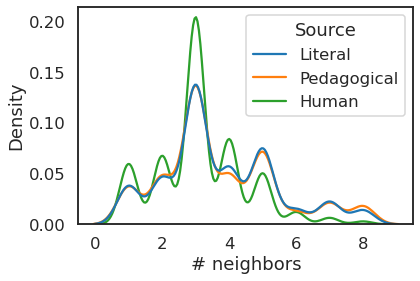

In [31]:
ax = sns.kdeplot(data=sim_vs_human, x='neighbors', hue='Source')
ax.set(xlabel='# neighbors')
plt.savefig('plots/neighbors_sim_vs_human.png', bbox_inches='tight')

## Fig 5: Toy example

### Plot belief distributions

Assemble belief distributions:

In [32]:
winning_weights = param_dict['literal_pref_cost']
winning_pred = teach.utility_model_predictions(data=prob_data, sampling_fun=teach.strong_sampling, 
                                               pref_fun=teach.edge_pref, weights=winning_weights, nIter=1)
winning_pH = [dict(t['pH']) for t in winning_pred]
winning_pH.insert(0, dict(zip(['A', 'B' , 'C', 'D'], .25*np.ones(4))))

win_df = (
    pd.DataFrame(winning_pH)
    .reset_index()
    .rename(columns={'index': 't'})
    .melt(id_vars=['t'], value_vars=['A', 'B', 'C', 'D'], var_name='hypothesis', value_name='p')
)

win_df.head()

,t,hypothesis,p
0,0,A,0.25
1,1,A,0.50
2,2,A,1.00
3,3,A,1.00
4,0,B,0.25


Plot belief distributions over time:

/n/sw/eb/apps/centos7/Anaconda3/2020.11/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)
/n/sw/eb/apps/centos7/Anaconda3/2020.11/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


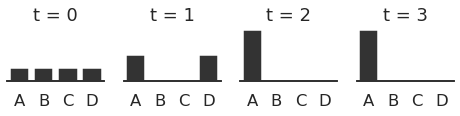

In [33]:
g = sns.catplot(data=win_df, x='hypothesis', y='p', col='t', kind='bar', color='#333', height=1, aspect=2)
g.set(xlabel='', ylabel='', yticks=[])
g.despine(left=True)

plt.savefig('plots/trial_by_trial_demo.png', bbox_inches='tight')

### Plot pTrue, KL over time:

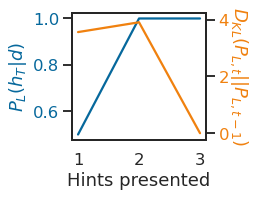

In [34]:
pTrue = [t['A'] for t in winning_pH[1:]]
KL = [kl_divergence(np.array(list(winning_pH[t-1].values())), np.array(list(winning_pH[t].values()))) for t in range(1,4)]

fig, ax = plt.subplots(figsize=(3*1.3,3))

# Plot linear sequence, and set tick labels to the same color
ax1_color ='#06689c'
ax.plot(pTrue, color=ax1_color)
ax.tick_params(axis='y', labelcolor=ax1_color)
ax.set_ylabel(r'$P_L(h_T | d)$', color=ax1_color)
ax.set(xlabel='Hints presented', xticks=[0, 1, 2], xticklabels=[1,2,3])

# Generate a new Axes instance, on the twin-X axes (same position)
ax2_color = '#F0810F'
ax2 = ax.twinx()

# Plot exponential sequence, set scale to logarithmic and change tick color
ax2.plot(KL, color=ax2_color)
ax2.tick_params(axis='y', labelcolor=ax2_color)
ax2.set_ylabel(r'$D_{KL}(P_{L,t} || P_{L,t-1})$', color=ax2_color, rotation=-90, labelpad=20)
ax2.set_ylim((-0.25, 4.25))

plt.tight_layout()

plt.savefig('plots/trial_by_trial_regressor_demo.png')

## Fig SXX: Time model

Draw bars:

In [65]:
pTrue = np.linspace(.25, 1, 4)
belief_list = []

for t,p in enumerate(pTrue):
    belief_t = np.zeros(4)
    belief_t[0] = p
    belief_t[1:] = (1-p)/3
    belief_list.append([t]+belief_t.tolist())
    
belief_df = pd.DataFrame(belief_list, columns=['t', 'A', 'B', 'C', 'D'])
pd.melt(belief_df, id_vars='t', variable='Hypothesis', value='pTrue')


TypeError: melt() got an unexpected keyword argument 'variable'

Load control regressors:

In [35]:
control_df = pd.read_csv('outputs/control_regressor_values.csv')
print(control_df.shape)
control_df.head()

(3213, 7)


,subject,run,block_idx,ex_idx,problem,pTrue,KL
0,1,7,2,0,0,-0.25463,-1.944137
1,1,7,2,1,0,-0.00463,-1.526076
2,1,7,2,2,0,0.24537,3.446987
3,1,1,2,0,1,-0.25463,-1.944137
4,1,1,2,1,1,-0.00463,-1.526076


Plot pTrue, KL over time:

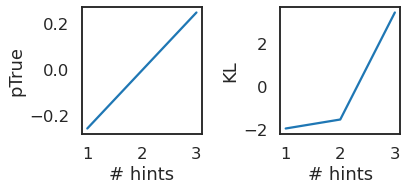

In [55]:
sample_problem = list(control_df.groupby(['subject', 'run', 'block_idx']))[1][1]

fig,axes=plt.subplots(1,2, figsize=(6,3))
axes[0].plot([1,2,3], sample_problem.pTrue)
axes[1].plot([1,2,3], sample_problem.KL)

axes[0].set(xlabel='# hints', ylabel='pTrue')
axes[1].set(xlabel='# hints', ylabel='KL')

plt.tight_layout()

In [49]:
sample_problem

((1, 1, 1),
     subject  run  block_idx  ex_idx  problem    pTrue        KL
 49        1    1          1       0       18 -0.25463 -1.944137
 50        1    1          1       1       18 -0.00463 -1.526076
 51        1    1          1       2       18  0.24537  3.446987)